# Flow matching for SBI
normal-normal sample

In [64]:
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal


In [73]:
class Flow(nn.Module):
    def __init__(self, dim_para: int = 2, dim_obs: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_para + dim_obs + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim_para))
    
    def forward(self, t: Tensor, x: Tensor, z_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x, z_t), -1))
    
    def step(self, z_t: Tensor, t_start: Tensor, t_end: Tensor, x: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(z_t.shape[0], 1)
        x = x.repeat(z_t.shape[0], 1)
        
        return z_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x = x, z_t= z_t + self(x = x, z_t=z_t, t=t_start) * (t_end - t_start) / 2)

## Training

In [82]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

mu_prior = torch.tensor([-6.0,10.0])
sigma_prior = torch.tensor([[8.0,1.0],[1.0,2.0]])
sigma_likelihood = torch.tensor([[4.0,-2.0],[-2.0,5.0]])
batch_size = 256

for _ in range(10000):
    z_1 = MultivariateNormal(mu_prior, covariance_matrix=sigma_prior).sample((batch_size,))
    x = z_1 + MultivariateNormal(torch.tensor([0.0,0.0]), covariance_matrix=sigma_likelihood).sample((batch_size,))
    
    z_0 = torch.randn_like(z_1)
    t = torch.rand(len(z_1), 1)
    
    z_t = (1 - t) * z_0 + t * z_1
    dx_t = z_1 - z_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, z_t=z_t, x=x), dx_t).backward()
    optimizer.step()

## Sampling

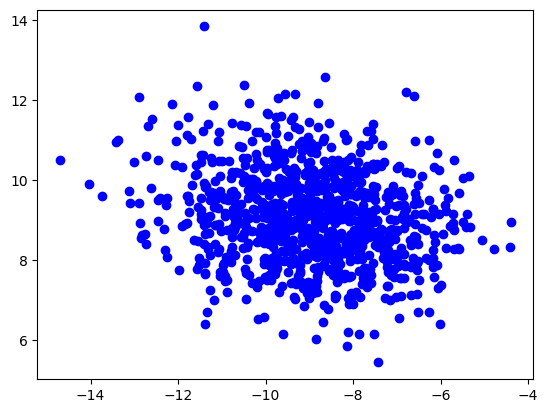

In [85]:
#observed data
obs = torch.tensor([-10.0,8.0])

#the number of samples from posterior
n_samples = 1000
#sample from z_0
para_post = torch.randn(n_samples,2)
#sample from observed data
# -----------------------------------------------------------------
n_steps = 10
time_steps = torch.linspace(0, 1.0, n_steps + 1)

for i in range(n_steps):
    para_post = flow.step(z_t=para_post, t_start=time_steps[i], t_end=time_steps[i + 1], x = obs)



## Plotting

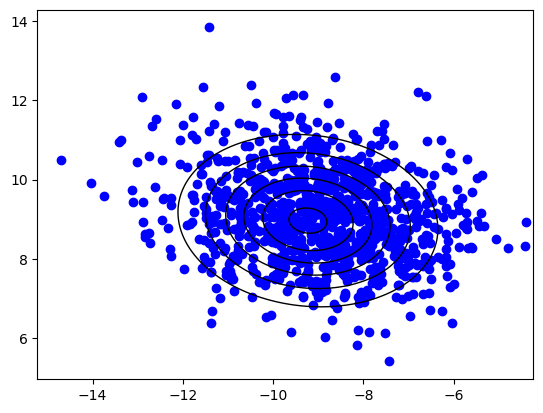

In [89]:
# theoretical posterior distribution para
sigma_post = torch.inverse(torch.inverse(sigma_likelihood)+torch.inverse(sigma_prior))
mu_post = sigma_post @ (torch.inverse(sigma_likelihood) @ obs + torch.inverse(sigma_prior) @ mu_prior)

grid_size = 200
x_min, x_max = mu_post[0] - 5, mu_post[0] + 5
y_min, y_max = mu_post[1] - 4, mu_post[1] + 4

x = torch.linspace(x_min, x_max, grid_size)
y = torch.linspace(y_min, y_max, grid_size)
X, Y = torch.meshgrid(x, y, indexing='xy')

pos = torch.stack([X, Y], dim=-1)

mvn = MultivariateNormal(mu_post, covariance_matrix=sigma_post)
Z = torch.exp(mvn.log_prob(pos))

#plot contour of theoretical posterior distribution
plt.contour(X, Y, Z, colors='black', linewidths=1)
#plot scatter of samples
plt.scatter(para_post.detach()[:, 0], para_post.detach()[:, 1], c='blue')
plt.show()